In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import scipy.stats
from scipy.integrate import odeint
import pymc3 as pm
import arviz as az
import sunode
import sunode.wrappers.as_theano
# sunode object to customise solver configs
lib = sunode._cvodes.lib
import warnings
warnings.filterwarnings('ignore')

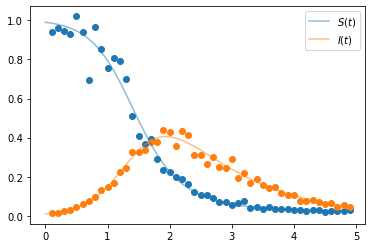

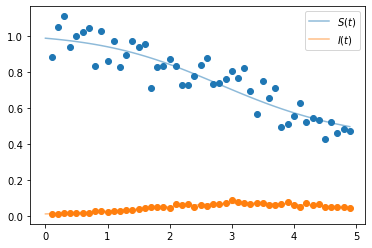

In [2]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    #'R': p[2] * p[1] * y[1] ## f in considered as 1 for this exercice
    return [ds, di]

# lengh of the ode observations
n_groups = 2
sample_period = 0.1
times = np.arange(0, 5, sample_period)
cases_obs = [0] * n_groups

# group 1
lam, mu = 4.0, 1.0

y = odeint( # solves a system of ordinary differential equations using lsoda
    SIR, # ode np array formulas
    t=times, # A sequence of time points for which to solve for y
    y0=[0.99, 0.01], # initial values
    args=((lam, mu),), # parameters for the ode equations
    rtol=1e-8 # solver error control
)
# lognormal uncertainty addition
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.1, 0.1])
cases_obs[0] = yobs[:,1]

# plots synthetic cases obs
plt.plot(times[1::], yobs, marker='o', linestyle='none') 
# plot integrated curve from the ods eqs
plt.plot(times, y[:, 0], color='C0', alpha=0.5, label=f'$S(t)$') 
plt.plot(times, y[:, 1], color='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

## group 2 - equal the above one
lam, mu = 3.0, 2.0
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((lam, mu),), rtol=1e-8)
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.1, 0.1])
cases_obs[1] = yobs[:,1]

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:, 0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:, 1], color='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

In [3]:
def SIR_sunode(t, y, p):
        return {
            'S': -p.lam * y.S * y.I,
            'I': p.lam * y.S * y.I - p.mu * y.I,
            #'R': p.f * p.mu * y.I ## f in considered as 1 for this exercice
        }
cases_obs_array = np.array(cases_obs).T 
#sample_period = covid_data.sample_period
#cases_obs = covid_data.cases_obs
time_range = np.arange(0,len(cases_obs_array)) * sample_period
#     self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)

I0 =  cases_obs_array[0] #np.array(cases_obs)[:, 1] #covid_data.data[0]
S0 = 1 - I0
# data is already scaled
S_init = S0 
I_init = I0 
cases_obs_scaled = cases_obs_array# covid_data.data 

In [5]:
with pm.Model() as model4:
                       
    # ------------------- Setup the priors and hyperpriors ---------------#

    prior_lam = pm.Lognormal('prior_lam', 1.5, 1.5) 
    prior_mu = pm.Lognormal('prior_mu', 1.5, 1.5)
    prior_lam_std = pm.HalfNormal('prior_lam_std', 1.0)
    prior_mu_std = pm.HalfNormal('prior_mu_std', 1.0)
    
    lam = pm.Lognormal('lambda', prior_lam , prior_lam_std, shape=2) # 0.75, 2
    mu = pm.Lognormal('mu', prior_mu , prior_mu_std, shape=2)           # 1.5, 1.5
    sigma = pm.HalfCauchy('sigma', 2, shape=2)

    # -------------------- ODE model --------------- #
                
    res, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
        y0={ # We need to specify the shape of each parameter. Any empty tuple corresponds to a scalar value.
           'S': (S_init, (2,)), 
           'I': (I_init, (2,))
        },
        params={
            'lam': (lam, (2,)),
            'mu': (mu, (2,)),
            '_dummy': (np.array(1.), ())
        },
        rhs=SIR_sunode,
        # The time points where we want to access the solution
        tvals=time_range[1:],
        t0=time_range[0],
    )
    
    ## raw sundials functions to customise sunode solver options
    ## powered by pysundials https://github.com/jmuhlich/pysundials/tree/master/doc
    lib.CVodeSStolerances(solver._ode, 1e-10, 1e-10)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-8, 1e-8)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-8, 1e-8)
    lib.CVodeSetMaxNumSteps(solver._ode, 5000)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 5000)
    
    # ------------------- Setup likelihoods for the observed data ---------------#
    ### why didnt he setup sigma as a RV? <- it takes the double of the time to sample it
    I = pm.Normal('I', mu=res['I'], sigma=sigma, observed=cases_obs_scaled[1:])

    R0 = pm.Deterministic('R0',lam/mu)

    # ------------------- Sample from the distribution ---------------#

    # if you increase the variance and the distributions looks choppy, increase the tuning sample size to sample the space more effectively
    # also, increase the total number of samples
    trace = pm.sample(8000, tune=2000, chains=4, cores=4)
    data = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu, lambda, prior_mu_std, prior_lam_std, prior_mu, prior_lam]



[CVODES WARNING]  CVode
  Internal t = 1.11056 and h = 9.56055e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.11056 and h = 9.56055e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.11056 and h = 9.56055e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.11056 and h = 9.56055e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.11056 and h = 9.56055e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.11056 and h = 9.56055e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 1.11056 and h = 9.56055e-17 are such that t + h = t on the next step. The solver will continue a


[CVODES WARNING]  CVode
  Internal t = 0.557899 and h = 4.86712e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.557899 and h = 4.86712e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.557899 and h = 4.86712e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.557899 and h = 4.86712e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.557899 and h = 4.86712e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.557899 and h = 4.86712e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.557899 and h = 4.86712e-17 are such that t + h = t on the next step. The solver will con


[CVODES WARNING]  CVode
  Internal t = 0.504628 and h = 4.25367e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.504628 and h = 4.25367e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.504628 and h = 4.25367e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.504628 and h = 4.25367e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.504628 and h = 4.25367e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.504628 and h = 4.25367e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.504628 and h = 4.25367e-17 are such that t + h = t on the next step. The solver will con


[CVODES WARNING]  CVode
  Internal t = 0.0634953 and h = 5.7203e-18 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.0634953 and h = 5.7203e-18 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.0634953 and h = 5.7203e-18 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.0634953 and h = 5.7203e-18 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.0634953 and h = 5.7203e-18 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.0634953 and h = 5.7203e-18 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.0634953 and h = 5.7203e-18 are such that t + h = t on the next step. The solver will con


[CVODES ERROR]  CVode
  At t = 0.00390904 and h = -1.50788e-08, the error test failed repeatedly or with |h| = hmin.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 4.8 and h = -4.71808e-23, the error test failed repeatedly or with |h| = hmin.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0 and h = 3.7591e-30, the error test failed repeatedly or with |h| = hmin.


[CVODES ERROR]  CVode
  At t = 0 and h = 3.7591e-30, the error test failed repeatedly or with |h| = hmin.


[CVODES WARNING]  CVode
  Internal t = 0.911635 and h = 4.70173e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.911635 and h = 4.70173e-17 are such that t + h = t on the next step. The solver will continue anyway.


[CVODES WARNING]  CVode
  Internal t = 0.911635 and h = 4.70173e-17 are such that t + h = t on the nex

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_lam,1.224,0.409,0.341,1.958,0.004,0.003,10452.0,6866.0,1.0
prior_mu,0.590,0.426,0.027,1.313,0.003,0.002,14787.0,12786.0,1.0
prior_lam_std,0.557,0.412,0.069,1.328,0.004,0.003,10451.0,13591.0,1.0
prior_mu_std,0.733,0.433,0.175,1.555,0.003,0.002,19523.0,18759.0,1.0
lambda[0],3.996,0.039,3.920,4.069,0.000,0.000,20870.0,17516.0,1.0
lambda[1],2.991,0.050,2.897,3.083,0.000,0.000,19476.0,17834.0,1.0
mu[0],1.014,0.015,0.984,1.042,0.000,0.000,20323.0,13453.0,1.0
mu[1],1.990,0.034,1.928,2.055,0.000,0.000,19621.0,17877.0,1.0
sigma[0],0.022,0.002,0.018,0.027,0.000,0.000,21234.0,15896.0,1.0
sigma[1],0.006,0.001,0.005,0.007,0.000,0.000,15371.0,7349.0,1.0


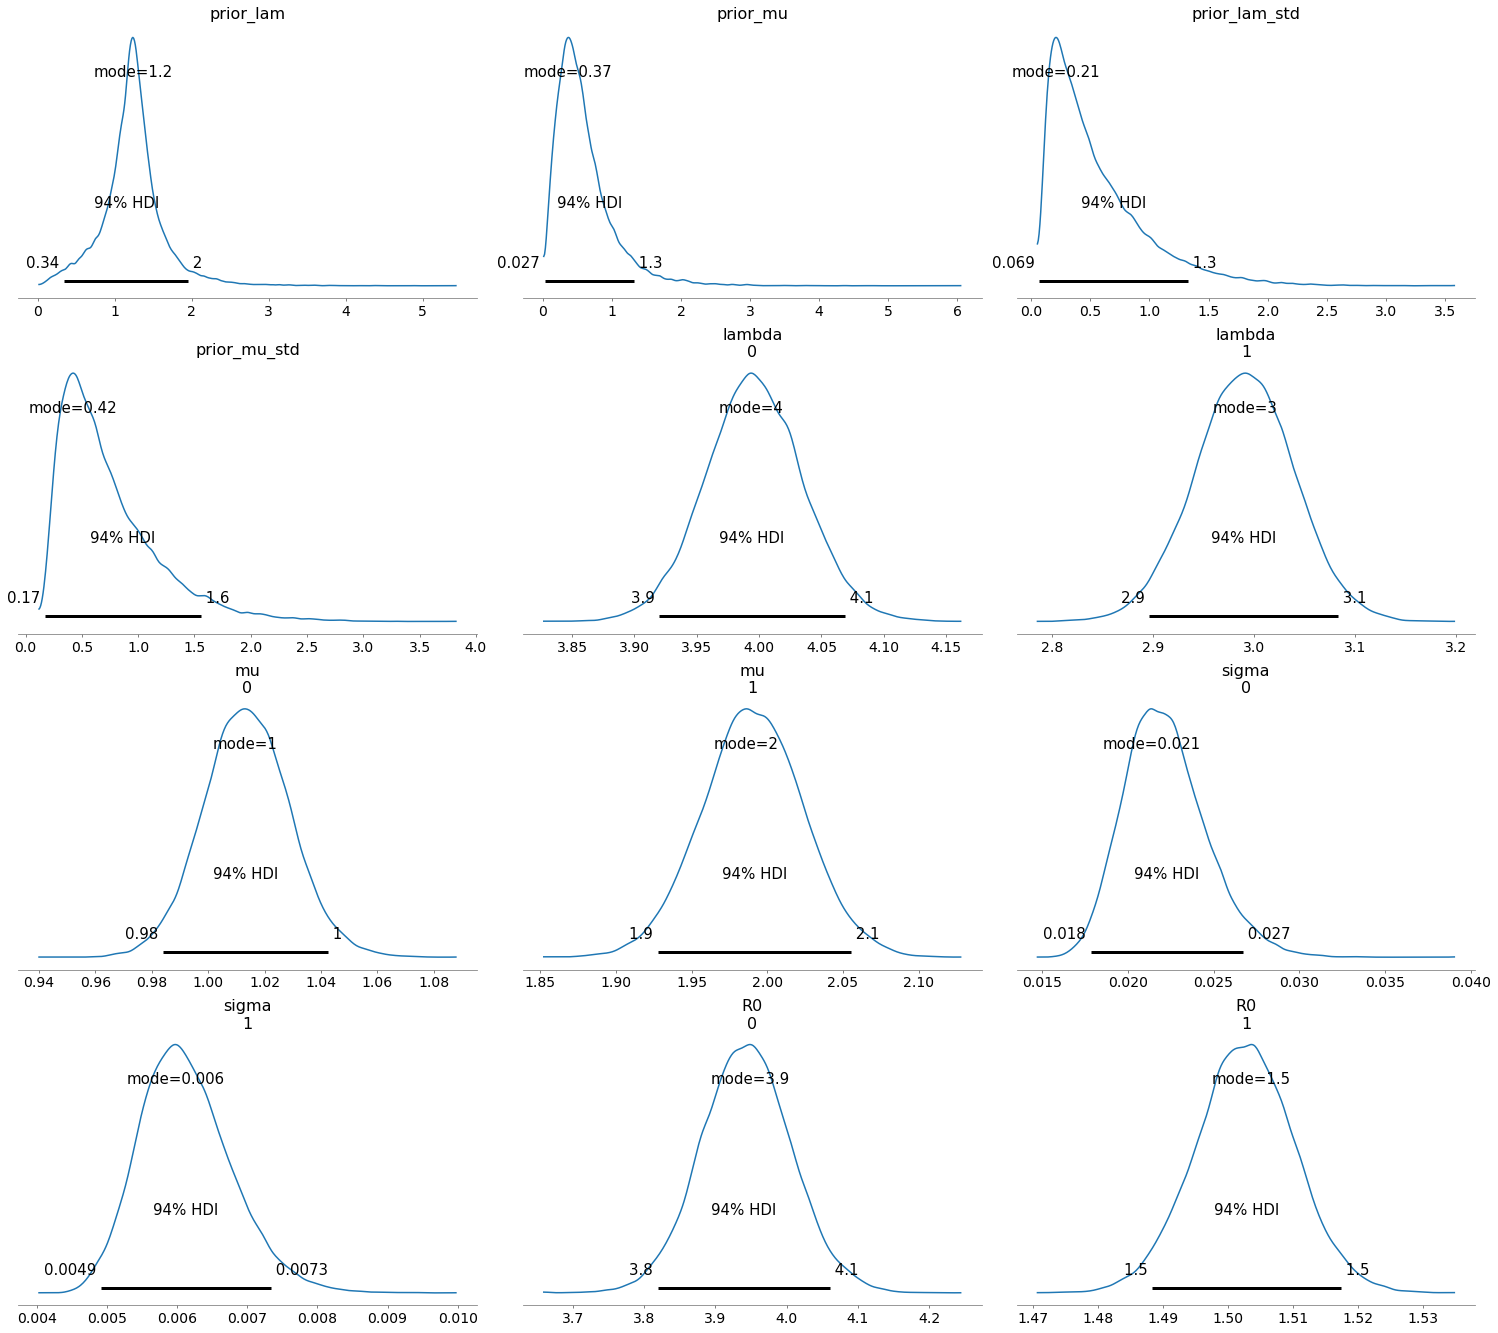

In [6]:
az.plot_posterior(data, point_estimate='mode', round_to=2)
az.summary(trace)

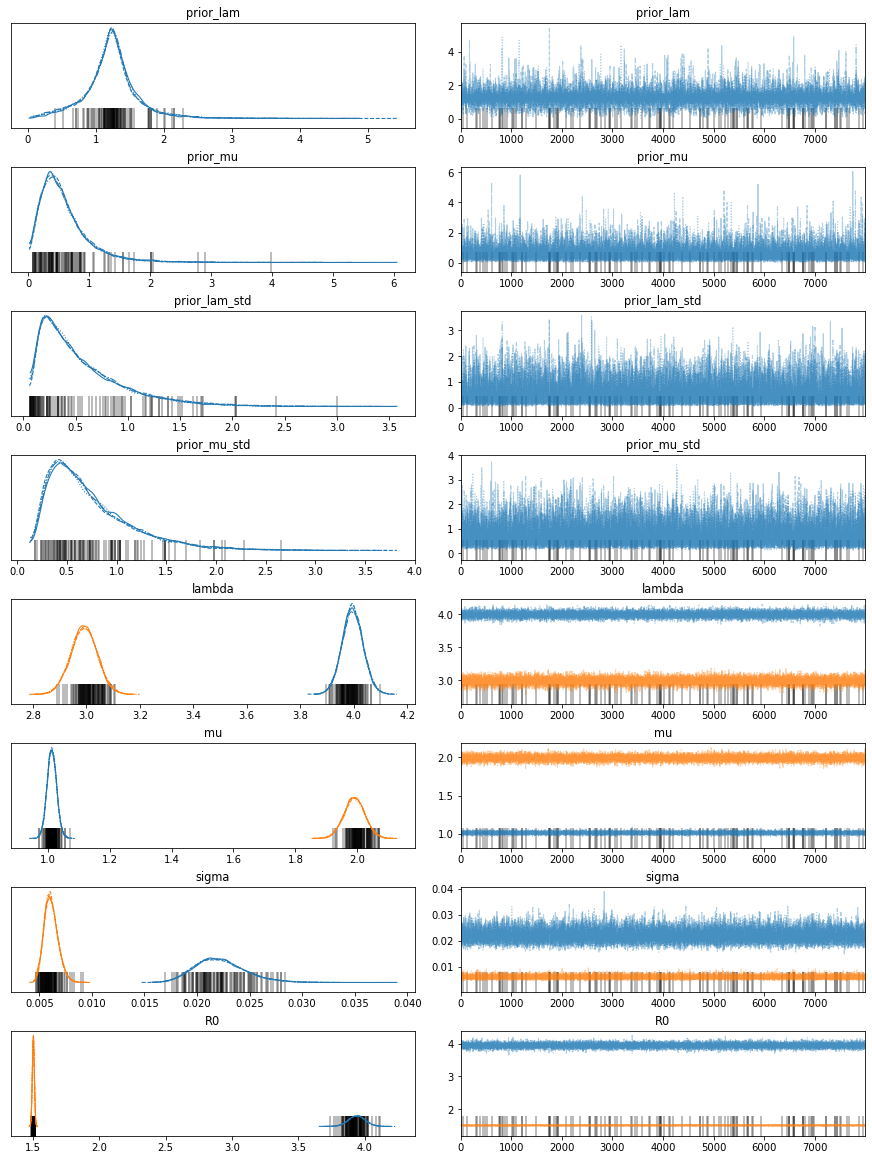

In [7]:
az.plot_trace(trace);